# **Diversion Data Exploratory Analysis**

Author: Bridget Bittmann

Date Created: 09/14/2021

Date Modified: 09/14/2021

In [ ]:
#Import necessary packages

import pandas as pd #to work with data arrays
!pip install geopandas
import geopandas as gpd #to work with spatial data
import numpy as np #to work with arrays and statistics
import matplotlib.pyplot as plt #create graphs 
from matplotlib.dates import DateFormatter
import glob #to batch import csv files

In [2]:
#Navigate to your directory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Navigate to workspace

%cd /content/drive/MyDrive/spatial_colab/
%ls

/content/drive/MyDrive/spatial_colab
1986.tif  1988.tif  1990.tif  1992.tif  datasets/
1987.tif  1989.tif  1991.tif  1993.tif  pod_pou_lulcc/


In [4]:
#Import data files

div_wd63 = pd.read_csv('datasets/diversion_timeseries/WD63.csv', parse_dates=['DiversionDate'], index_col=['DiversionDate'])
print(div_wd63.dtypes)

WaterDistrictNumber             int64
HydrologyID                     int64
DiversionName                  object
DiversionTypeDescription       object
MeasurementTypeDescription     object
CFS                           float64
dtype: object


In [ ]:
### CREATE A CSV FILE FOR EACH DIVERSION ###

#This section is useful to clean, sort, and individually export each csv
#Can comment section out after first run 

# div_name = np.unique(div_wd63['DiversionName']) #get unique identifier for each div point
# print(div_name)

# for n in div_name:
#   canal = div_wd63[div_wd63['DiversionName']== n] #creates a dataframe for each canal name
#   canal = canal.sort_index() #sorts data by date
#   file_name = 'datasets/diversion_timeseries/'+ str(n) +'.csv' #creates a file path
#   canal.to_csv(file_name) #exports csv to directory

In [5]:
### IMPORT ALL NEW CSV FILES INTO ONE DATAFRAME ###


all_files = [] #creates a list space for all the dataframes

csv = glob.glob('datasets/diversion_timeseries/individual_canals/*.csv') #name for all the csv files
for f in csv: 
  df = pd.read_csv(f, parse_dates=['DiversionDate'], index_col=['DiversionDate'])
  all_files.append(df) #appends dataframes to one file list

In [ ]:
#Plot the data to see the timescale

###----------------------------------###
### CREATES ONE FIGURE FOR ALL PLOTS ###
###----------------------------------###

len(all_files)
i,j = 0,0
plot_row = 4 #number of plots per row in figure
figure, ax = plt.subplots(33, plot_row, figsize=(30,150)) #create the figure
file_len = np.array(np.arange(0,len(all_files),1)) #total count of files

for f in file_len: #run a for loop to add all plots to figure
  canal_data = all_files[f] #takes an individual diversion point datafram
  ax[i][j].plot(canal_data.index, canal_data['CFS'], 'o')
  ax[i][j].set_ylabel('Discharge (cfs)')
  ax[i][j].set_xlabel('Time')
  ax[i][j].title.set_text(canal_data['DiversionName'].iloc[0])
  j+=1
  if j%plot_row==0:
    i+=1
    j=0

###---------------------------------------------###
### CREATES INDIVIDUAL PLOTS FOR EACH DIVERSION ###
###---------------------------------------------###

for f in file_len:
  canal_data = all_files[f]
  fig = plt.figure(figsize= (9,7))
  ax = fig.add_subplot(1,1,1)
  ax.plot(canal_data.index, canal_data['CFS'], 'o')
  ax.set_ylabel('Discharge (cfs)')
  ax.set_xlabel('Time')
  ax.title.set_text(canal_data['DiversionName'].iloc[0])
  file_path = ('datasets/diversion_timeseries/individualplots/'+ canal_data['DiversionName'].iloc[0] +'.png')
  plt.savefig(file_path) #exports the file 


In [6]:
## EXPLORATORY DATA ANALYSIS ##

## Start with 4 known canals: Ridenbaugh, Settlers, Phyllis, Riverside

main_canals = ([all_files[84], all_files[94], all_files[77], all_files[85]])  #subset to the 4 canals
years = np.array(np.arange(2003,2021,1)) #creates an array for the years
totals = np.empty((len(years), len(main_canals))) #create an empty vector to store sums
names = []
for i in range(len(main_canals)):
  sub_canal = main_canals[i]['DiversionName']
  names.append(sub_canal[1])

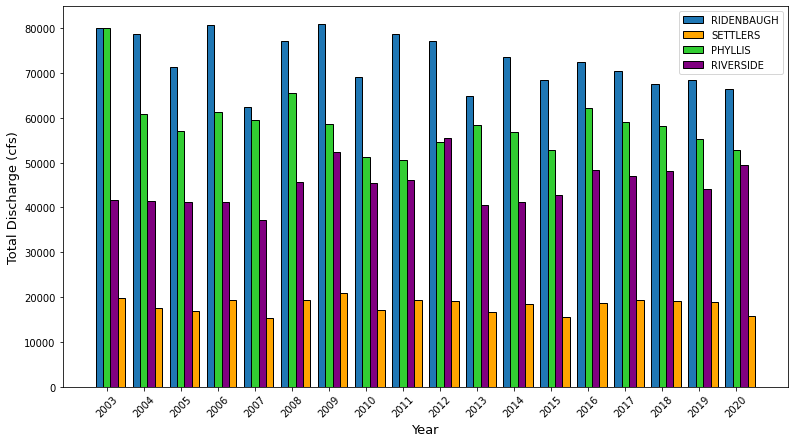

In [7]:
### FIND THE TOTAL WATER DIVERTED ANNUALLY ###

for i in range(len(main_canals)):
  for y in range(len(years)):
    sub_canal = main_canals[i]
    Ix = sub_canal.index.year == years[y] #index the year
    subset_year = sub_canal[Ix] #subset the data to the specified year
    totals[y][i] = sum(subset_year['CFS']) #sum the total discharge throughout the year
    #need to find a way to normalize the total for the year

fig2 = plt.figure(figsize=(13,7)) #create a figure
width = 0.2
ax = fig2.add_subplot(1,1,1) #add a subplot
ax.bar(years-width, totals[:,0], width=width, edgecolor='black') #plot the data as a bar chart 
ax.bar(years+width*2, totals[:,1], width=width, color='orange', edgecolor='black')
ax.bar(years, totals[:,2], width=width, color='limegreen', edgecolor='black')
ax.bar(years+width, totals[:,3], width=width, color='purple', edgecolor='black')
ax.set_xlabel('Year', size=13) #set the x-axis label 
ax.set_ylabel('Total Discharge (cfs)', size=13) #set the y-axis label
plt.xticks(years, years, rotation= 45) #create label for all years
plt.legend(names)
plt.show()

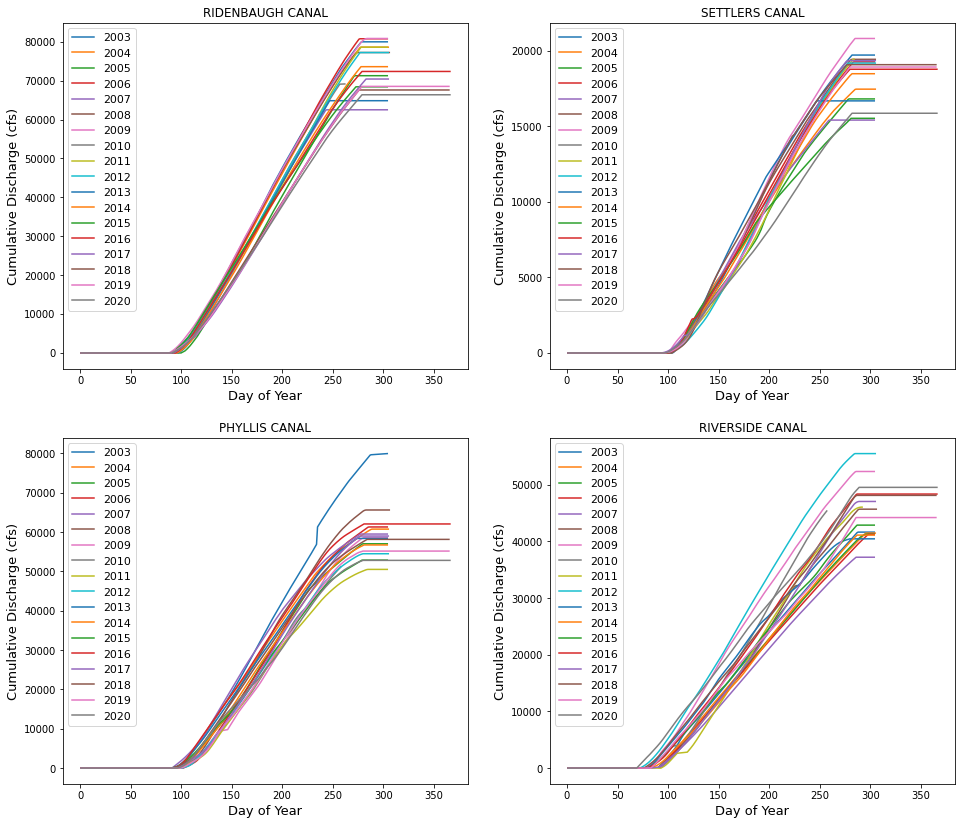

In [62]:
## CUMULATIVE SUMS DAILY ##

#Create a loop to sum the total water diverted for every year

cumsum_years = []
years = np.array(np.arange(2003,2021,1)) #creates an array for the years

for i in range(len(main_canals)):
  for j in range(len(years)):
    sub_canal = main_canals[i]
    Ix = sub_canal.index.year == years[j] #index the year
    subset_year = sub_canal[Ix] #subset the data to the specified year
    series_cfs = pd.Series(subset_year['CFS'])
    cumsum_daily = series_cfs.cumsum()
    cumsum_years.append(cumsum_daily)

#Plot the cumulative sum by the day of year

year = np.array(np.arange(0,72,1))
fig3 = plt.figure(figsize = (16,14))
ax = fig3.add_subplot(2,2,1)
ax1 = fig3.add_subplot(2,2,2)
ax2 = fig3.add_subplot(2,2,3)
ax3 = fig3.add_subplot(2,2,4)
for i in range(len(year)):
  if year[i]<18:
    ax.plot(cumsum_years[i].index.dayofyear, cumsum_years[i])
    ax.legend(years, fontsize=11)
    ax.set_ylabel('Cumulative Discharge (cfs)', size=13)
    ax.set_xlabel('Day of Year', size=13)
    ax.set_title(names[0]+' CANAL') #add the name of the canal
  elif year[i]<36:
    ax1.plot(cumsum_years[i].index.dayofyear, cumsum_years[i])
    ax1.legend(years, fontsize=11)
    ax1.set_ylabel('Cumulative Discharge (cfs)', size=13)
    ax1.set_xlabel('Day of Year', size=13)
    ax1.set_title(names[1]+' CANAL')
  elif year[i]<54:
    ax2.plot(cumsum_years[i].index.dayofyear, cumsum_years[i])
    ax2.legend(years, fontsize=11)
    ax2.set_ylabel('Cumulative Discharge (cfs)', size=13)
    ax2.set_xlabel('Day of Year', size=13)
    ax2.set_title(names[2]+' CANAL')
  else:
    ax3.plot(cumsum_years[i].index.dayofyear, cumsum_years[i])
    ax3.legend(years, fontsize=11)
    ax3.set_ylabel('Cumulative Discharge (cfs)', size=13)
    ax3.set_xlabel('Day of Year', size=13)
    ax3.set_title(names[3]+' CANAL')
plt.legend(years, fontsize=11)
plt.show()

In [85]:
## NORMALIZE THE LENGTH OF IRRIGATION SEASON ##

## Find the absolute maximum and minmum days for irrigation across all seasons and canals

min_day = []
max_day = []

for i in range(len(cumsum_years)):
  year_canal = cumsum_years[i]
  min_Ix = np.where(year_canal==np.min(year_canal))
  min_Ix = min_Ix[0]
  min_Ix = min_Ix[-1]
  min_day.append(year_canal.index[min_Ix])
  max_Ix = np.where(year_canal==np.max(year_canal))
  max_Ix= max_Ix[0]
  max_Ix = max_Ix[0]
  max_day.append(year_canal.index[max_Ix])

max_day = pd.DatetimeIndex(max_day)
min_day = pd.DatetimeIndex(min_day)
irrigation_start = min_day[np.where(min_day.dayofyear == np.min(min_day.dayofyear))]
irrigation_end = max_day[np.where(max_day.dayofyear == np.max(max_day.dayofyear))]

## Clip the datasets to be between irrgation_start and irrigation_end across all years




In [ ]:
## FIND THE DATE WHERE HALF OF THE FLOW HAS GONE THROUGH ##

def nearest(Data, search_value):
  '''
  Define a function to find the date with the value closet to search value
  
  INPUTS:
  Data = the set of data you are searching through
  search_value = the value you want to be closest to

  OUTPUTS:
  Indexed value closest to search value
  '''
  Ix = (np.abs(Data-search_value)).argmin()
  return Data[Ix]

#Use a loop to find the date where half of the diversion flow has passed through
#the system

mid_dates = []
for i in range(len(years)):
  subset_year = cumsum_years[i]
  half_fill = round(0.5*max(subset_year))
  date = nearest(subset_year, half_fill)
  Ix_date = subset_year == date
  date = subset_year[Ix_date]
  mid_dates.append(date)

## Plot the dates where have of discharge has passed through the system

year_string = years.tolist()
fig5 = plt.figure(figsize=(15,7))
ax = fig5.add_subplot(1,1,1)
for i in range(len(years)):
  ax.plot(mid_dates[i].index.dayofyear, mid_dates[i], 'o')
  x,y = mid_dates[i].index.dayofyear.values, mid_dates[i]
  plt.annotate(year_string[i], (x,y), textcoords='offset points',
               xytext=(4,-10))
ax.set_ylabel('Cumulative Discharge (cfs)', size=13)
ax.set_xlabel('Day of Year', size=13)
plt.title('Date at Half of Cumulative Discharge for a Season', size=20)
plt.xticks()
plt.show()
  

In [ ]:
## NORMALIZE THE DATA FOR EACH YEAR ##

